# Problem Statement:
### Lyft, Inc. is a transportation network company based in San Francisco, California and operating in 640 cities in the United States and 9 cities in Canada. It develops, markets, and operates the Lyft mobile app, offering car rides, scooters, and a bicycle-sharing system. It is the second largest rideshare company in the world, second to only Uber.
### Lyft’s bike-sharing service is also among the largest in the USA. Being able to anticipate demand is extremely important for planning of bicycles, stations, and the personnel required to maintain these. This demand is sensitive to a lot of factors like season, humidity, rain, weekdays, holidays, and more. To enable this planning, Lyft needs to rightly predict the demand according to these factors


## Import The Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


### Load the data file

In [2]:
df = pd.read_csv('hour.csv')
df.shape

(17379, 17)

In [3]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


### Check for null values in the data, drop records with NAs

In [6]:
df.isna().sum(axis=0)

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Looks like there are no records with null values. Looks good so far.

## 3.	Sanity checks:
### a.	Check if registered + casual = cnt for all the records. The two must add to cnt, if not the row is junk and should be dropped


In [7]:
np.sum((df.casual + df.registered) != df.cnt)

0

### Month values should be 1-12 only

In [8]:
np.unique(df.mnth)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

### Hour should be 0-23

In [9]:
np.unique(df.hr)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

### Variables ‘casual’, ‘registered’ are redundant and need to be dropped. ‘Instant’ is the index, and needs to be dropped too. The date column dteday will not be used in the model building, and hence needs to be dropped. Create new dataframe named ‘inp1’

In [10]:
cols_to_drop = ['casual', 'registered', 'dteday', 'instant']
df1 = df.drop(cols_to_drop, axis=1).copy()


In [11]:
df1.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


### Univariate analysis – Describe the numerical fields in the dataset using pandas describe method


In [12]:
df1.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000


### -	Make density plot for temp. This would give a sense of the centrality and the spread of the distribution

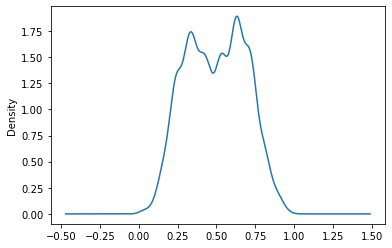

In [14]:
df1.temp.plot.density()
plt.show()

## -	Boxplot for atemp.
### Are there any outliers?


<IPython.core.display.Javascript object>

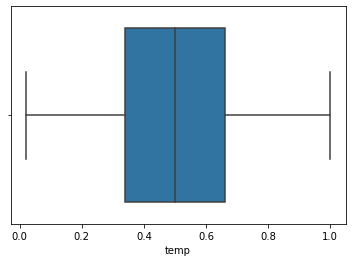

In [16]:
sns.boxplot(df1.temp)

### There don’t seem to be any outliers for temp.

## Histogram for hum
### Do you detect any abnormally high values?


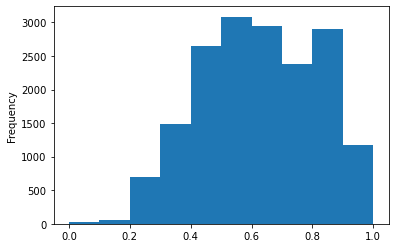

In [20]:
df1.hum.plot.hist()
plt.show()

### No visible abnormally high values

## Density plot for windspeed

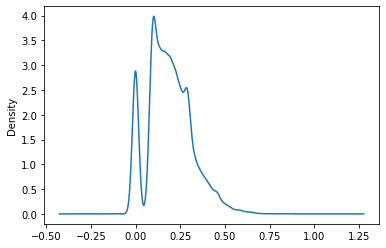

In [22]:
df1.windspeed.plot.density()
plt.show()

## Box and density plot for cnt – this is the variable of interest. 
### Do you see any outliers in the boxplot? 
### Does the density plot provide a similar insight?


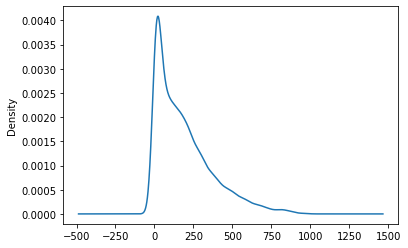

In [25]:
df1.cnt.plot.density()
plt.show()

<IPython.core.display.Javascript object>

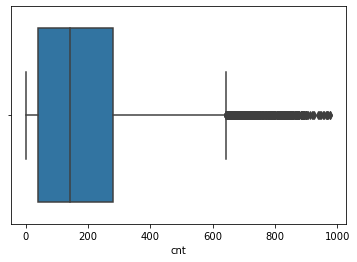

In [27]:
sns.boxplot(df1.cnt)
plt.show()

### Both plots show similar picture – some high values are present in cnt.

##  Outlier treatment – 
### Cnt – looks like some hours have rather high values of cnt. We’ll need to treat these outliers so that they don’t skew our analysis and our model. 
### Find out the following percentiles - 10, 25, 50, 75, 90, 95, 99
### Decide the cutoff percentile and drop records with values higher that the cutoff. Name the new dataframe ‘df2’.


In [29]:
df1.cnt.quantile([0.1, 0.25, 0.5, 0.70, 0.9, 0.95, 0.99])

0.10      9.00
0.25     40.00
0.50    142.00
0.70    244.00
0.90    451.20
0.95    563.10
0.99    782.22
Name: cnt, dtype: float64

### 563 is the 95th percentile – only 5% records have a value higher than this. Taking this as the cutoff.

In [31]:
df2 = df1[df1.cnt < 563].copy()

## Bi-variate analysis
### Make box plot for cnt vs hr
### What kind of pattern do you see?


<IPython.core.display.Javascript object>

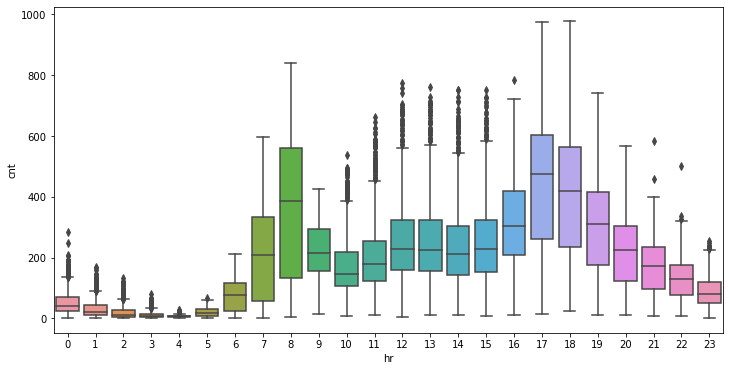

In [34]:
plt.figure(figsize=[12,6])
sns.boxplot("hr", "cnt", data=df1)
plt.show()

### It’s evident that the peak hours are 5PM – 7PM, the hours 7-8AM also have high upper quartile. A hypothesis could be that a lot of people use the bikes for commute to workplace and back.

## Make boxplot for cnt vs weekday
### Is there any difference in the rides by days of the week?


<IPython.core.display.Javascript object>

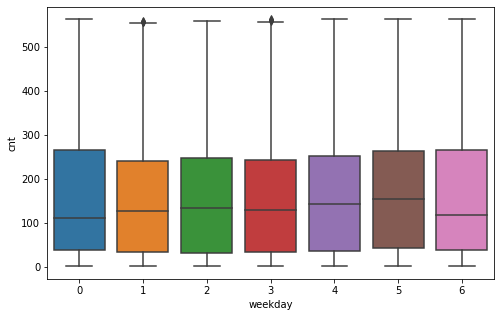

In [36]:
plt.figure(figsize=[8,5])
sns.boxplot("weekday", "cnt", data=df2)
plt.show()

## Make boxplot for cnt vs month
### Look at the median values. Any month(s) that stand out?


<IPython.core.display.Javascript object>

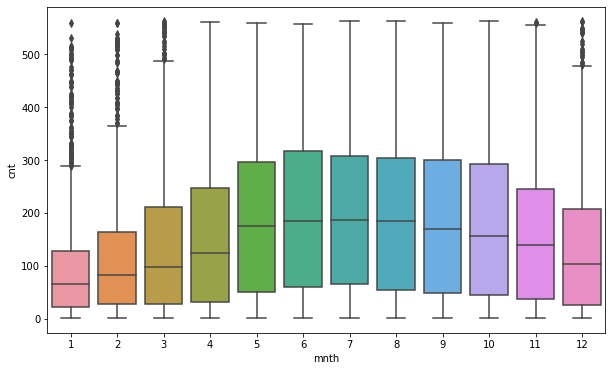

In [37]:
plt.figure(figsize=[10,6])
sns.boxplot("mnth", "cnt", data=df2)
plt.show()

## Looks like end of winter/ early spring months have the least bike riding instances.

## Make boxplot for cnt vs season
### Which season has the highest rides in general? Expected?


<IPython.core.display.Javascript object>

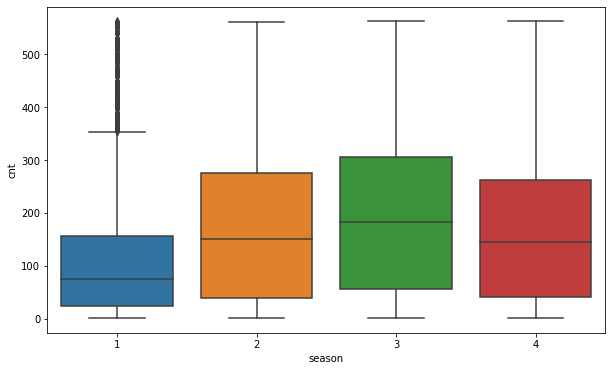

In [39]:
plt.figure(figsize=[10,6])
sns.boxplot("season", "cnt", data=df2)
plt.show()

## Make a correlation matrix for variables – atemp, temp, hum, windspeed
### Which variables have the highest correlation?


In [42]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed']
corrs = df2[num_vars].corr()


<IPython.core.display.Javascript object>

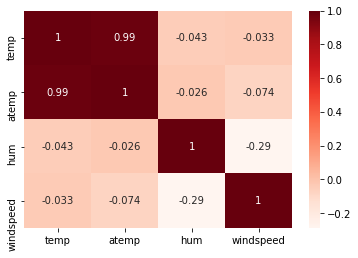

In [43]:
sns.heatmap(corrs, annot=True, cmap="Reds")

##  Data pre-processing
A few key considerations for the pre-processing – 
We seem to have plenty of categorical features. Since these categorical features can’t be used in the predictive model, we need to convert to a suitable numerical representation. Instead of creating dozens of new dummy variables, we will try to club levels of categorical features wherever possible. For a feature with high number of categorical levels, we can club the values that are very similar in value for the target variable 
First, create a copy of the dataframe into inp3
1.	Treating ‘mnth’ column
a.	For values 5,6,7,8,9,10 – replace with a single value 5. This is because these have very similar values for cnt.
b.	Get dummies for the updated 6 ‘mnth’ values


In [44]:
df3 = df2.copy()
df3.mnth[df3.mnth.isin([5,6,7,8,9])] = 5
np.unique(df3.mnth)


<ipython-input-44-a48f600496f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.mnth[df3.mnth.isin([5,6,7,8,9])] = 5


array([ 1,  2,  3,  4,  5, 10, 11, 12], dtype=int64)

## Treating ‘hr’ column
### Create new mapping: 0-5: 0, 11-15: 11, other values are untouched. Again, the bucketing is done in a way that hr values with similar levels of cnt are treated the same


In [45]:
df3.hr[df3.hr.isin([0,1,2,3,4,5])] = 0
df3.hr[df3.hr.isin([11,12,13,14,15])] = 11


<ipython-input-45-bb2954489948>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.hr[df3.hr.isin([0,1,2,3,4,5])] = 0
<ipython-input-45-bb2954489948>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.hr[df3.hr.isin([11,12,13,14,15])] = 11


In [46]:
np.unique(df3.hr)

array([ 0,  6,  7,  8,  9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23],
      dtype=int64)

### Get dummy columns for season, weathersit, weekday, mnth, hr. We needn’t club these further, because as seen from the box plots, the levels seem to have different values for the median cnt. 

In [47]:
cat_cols = ['season', 'weathersit', 'weekday', 'mnth', 'hr']
df3 = pd.get_dummies(df3, columns=cat_cols, drop_first=True)


In [48]:
df3.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_2', 'season_3', 'season_4', 'weathersit_2',
       'weathersit_3', 'weathersit_4', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_10', 'mnth_11', 'mnth_12', 'hr_6', 'hr_7', 'hr_8',
       'hr_9', 'hr_10', 'hr_11', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23'],
      dtype='object')

##  Train test split – apply 70-30 split
### call the new dataframes df_train, df_test


In [50]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df3, train_size = 0.7, random_state = 100)


###  Separate X and Y for df_train and df_test. For example – you should have X_train, y_train from df_train. y_train should be the cnt column from inp3, X_train should be all other columns.

In [53]:
y_test = df_test.pop("cnt")
X_test = df_test


## Model building
### Use Linear regression as the technique
### Report the R2 on the train set


In [56]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [57]:
from sklearn.metrics import r2_score
y_train_pred= lr.predict(X_train)
r2_score(y_train, y_train_pred)


0.6702614763740045

In [58]:
y_test_pred= lr.predict(X_test)
r2_score(y_test, y_test_pred)


0.6645042628350181